In [49]:
import cv2

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from scipy.signal import savgol_filter
# logger = logging.getLogger(__name__)

%matplotlib inline
def getedgeIndexes(res):
    a,b=np.histogram(res,50)
    a[a<len(res)*0.002]=0
    idxs=np.where(a==0)
    res[res<=b[idxs[0][0]]]=0
    res[res>=b[idxs[0][0]]]=1
    diff=np.diff(res)
    # diff=np.diff(res)
    return np.where(diff!=0)
def cleanbigarray(idyes):
    if len(idyes)>2:
        diff=np.diff(idyes)
    #         print(diff)
        idy=np.argmax(diff)
        return np.array([idyes[idy],idyes[idy+1]])
    else:
        return idyes
        
def getSectionBoundary(gray): #with 0 and 1s
    thresh=gray.mean()
    gray[gray<=thresh]=1
    gray[gray>=thresh]=0
    resx=gray.sum(axis=0)
    resy=gray.sum(axis=1)
    idxes=getedgeIndexes(resx)
    idyes=getedgeIndexes(resy)
    idxes,idyes=idxes[0],idyes[0]
    idyes=cleanbigarray(idyes)
    idxes=cleanbigarray(idxes)
    return idxes,idyes

datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\rawimages\\'
file='to_track.png'
file='0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730.tif'
# file='0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.png'
file='0128_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ B-129.tif'
file='0048_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-109.tif'
# file='0054_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-117.tif'
file=r'C:\Users\ArunBabu\OneDrive - ANTELOPUS ENERGY PRIVATE LIMITED\Python\Digitization\Image2Segy\im2segy_app\clipped_im.png'

In [55]:
# image = cv2.imread(datafolder+file)
image = cv2.imread(file)
oh,ow,_=image.shape
print(oh,ow)
if oh>4500:
    fact=int(100*4500/oh)/100
    image = cv2.resize(image, (0, 0), fx = fact, fy = fact)
oh,ow,_=image.shape
print(oh,ow)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

xs,ys=gray.shape

idxes,idyes=getSectionBoundary(gray)
# idxes,idyes=np.round(idxes*orxs/xs).astype(int),np.round(idyes*orys/ys).astype(int)
idxes,idyes

3759 24452
3759 24452


(array([   80, 22568], dtype=int64), array([ 366, 3580], dtype=int64))

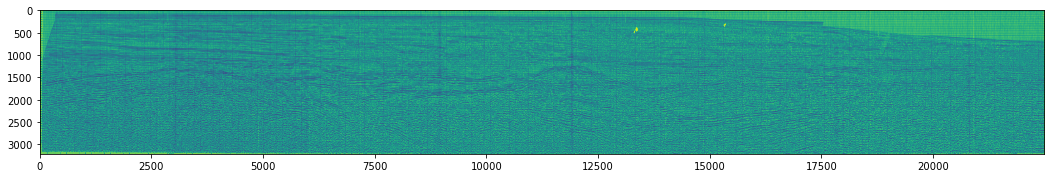

In [56]:
clipped_im=image[idyes[0]:idyes[1],idxes[0]:idxes[1],:]
# clipped_im=image
clipped_im=cv2.cvtColor(clipped_im, cv2.COLOR_BGR2GRAY)

# thresh=clipped_im.mean()
# clipped_im[clipped_im<=thresh]=1
# clipped_im[clipped_im>=thresh]=0

plt.figure(figsize=(18,6))
plt.imshow(clipped_im)

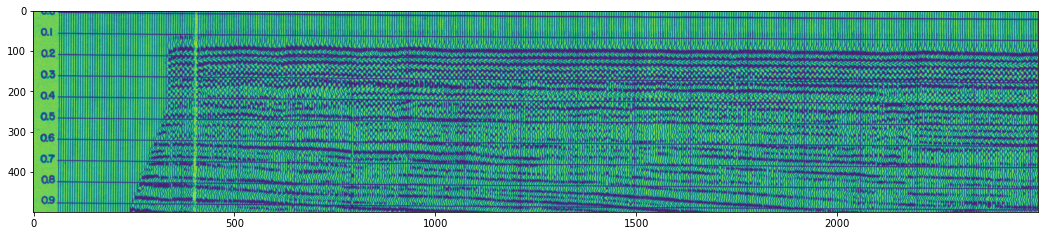

In [57]:
plt.figure(figsize=(18,6))
plt.imshow(clipped_im[:500,:2500])

In [58]:
h,w=clipped_im.shape
selim=clipped_im[:int(h/10),:int(w/55)]
horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
rows,cols = horizontal.shape
# horizontalsize = 30
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,2))
# horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
selim=horizontal.astype(float)

# selim[selim<=127.0]=1
# selim[selim>127.0]=0
res=selim.sum(axis=1)
mindx=np.argmin(res)
checkval=np.mean(res)-2*np.std(res)
idxs=np.where(res<checkval)[0]
idxs,mindx

(array([  3,   4,   5,   6,  56,  57,  58, 109, 110, 111, 162, 163, 164,
        214, 215, 216, 217, 267, 268, 269], dtype=int64),
 5)

In [59]:
def findHorlineIndex(clipped_im,horizontalsize=30):
    h,w=clipped_im.shape
    selim=clipped_im[:int(h/10),:int(w/55)]
    horizontal = cv2.adaptiveThreshold(selim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
    rows,cols = horizontal.shape
    # horizontalsize = 30
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,2))
    # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
    horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))
    selim=horizontal.astype(float)

    # selim[selim<=127.0]=1
    # selim[selim>127.0]=0
    res=selim.sum(axis=1)
    mindx=np.argmin(res)
    checkval=np.mean(res)-2*np.std(res)
    idxs=np.where(res<checkval)[0]
    if mindx==idxs[0]:
        return mindx
    else:
        return idxs[0]
#     #     return np.argmin(res)
for i in range(5,50,5):
    print(findHorlineIndex(clipped_im,horizontalsize=i))
# plt.figure(figsize=(18,6))
# plt.imshow(selim)

3
3
3
3
3
3
3
3
3


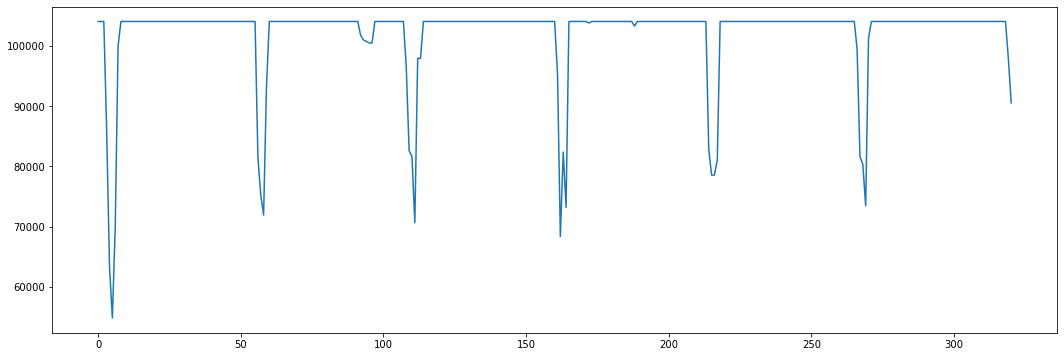

In [60]:
plt.figure(figsize=(18,6))
plt.plot(res)
# np.argmin(res)

In [27]:
def getCleanedCurve(shifts2bapplied,returnsmooth=False):
    # mav=movAverage(shifts2bapplied,5)
    x=np.arange(len(shifts2bapplied))
#     y=idxs
    z = np.polyfit(x, shifts2bapplied, 3)
    f = np.poly1d(z)
    mav = f(x)
#     mav = savgol_filter(shifts2bapplied, 101, 3) # window size 51, polynomial order 3
    pttable=shifts2bapplied>mav+1
    nttable=shifts2bapplied<mav-1
    if sum(pttable)>0: shifts2bapplied[pttable]=mav[pttable]+1
    if sum(nttable)>0:shifts2bapplied[nttable]=mav[nttable]-1
    if returnsmooth:
        return mav.astype(int)
    return shifts2bapplied
def getColumnShifts(clipped_im,zerotlineid):
    mp=zerotlineid
    pad=int(clipped_im.shape[0]/30)
    fpad,bpad=pad,pad
    #     print(mp,pad)
    if pad>mp:
        fpad=mp
    resim=clipped_im[mp-fpad:mp+bpad,:]

    horizontal = cv2.adaptiveThreshold(resim,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)
    rows,cols = horizontal.shape
    horizontalsize=10
    #     print('horizontalsize',horizontalsize)
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
    # horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
    horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))

    resim=horizontal.astype(float)
    width=5
    ncols=horizontalsize
    mfilter=np.vstack([np.zeros((width,ncols))-0.5,np.ones((width,ncols)),np.zeros((width,ncols))-0.5])
    opencvOutput = cv2.filter2D(resim, -1, mfilter)
    ffpad=3 if fpad/2 >3 else int(fpad/2 )
    fbpad=3
    midxs=[]
    window=10
    for i in range(window,opencvOutput.shape[1],window):
        start,endx=mp-ffpad,mp+fbpad
        if start<0:
            start=0
        poo=opencvOutput[start:endx,i-window:i]    
    #     print(i)
        idxs=np.argmin(poo,axis=0)
        nowidxs=start+idxs

        # poo=opencvOutput[mp-ffpad:mp+fbpad,i-window:i]    
        # idxs=np.argmin(poo,axis=0)
        # nowidxs=mp-ffpad+idxs
        midxs.extend(list(nowidxs))
        mp=int(np.mean(nowidxs))
    poo=opencvOutput[mp-ffpad:mp+fbpad,i:]    
    idxs=np.argmin(poo,axis=0)
    nowidxs=mp-ffpad+idxs
    midxs.extend(list(nowidxs))
    return np.arange(len(midxs)), np.array(midxs)
def getStraightenedImage(clipped_im,colnumbers,shifts2bapplied):
    # shifted_image=np.zeros_like(clipped_im).astype(np.uint8)
    shifted_image=clipped_im.copy()
    shape=clipped_im.shape
    if len(shape)==2:

    # idlist=np.arange(nonzeroid,len(linelocations)+nonzeroid)
        for i,cor in zip(colnumbers,shifts2bapplied):
            if cor!=0:
                shifted_image[:-cor,i]=clipped_im[cor:,i]
            else:
                shifted_image[:,i]=clipped_im[:,i]
    else:
        for i,cor in zip(colnumbers,shifts2bapplied):
            if cor!=0:
                shifted_image[:-cor,i,:]=clipped_im[cor:,i,:]
            else:
                shifted_image[:,i,:]=clipped_im[:,i,:]
    return shifted_image

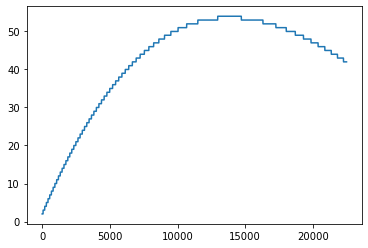

In [61]:
# findHorlineIndex(clipped_im,horizontalsize=30)
zerotlineid=findHorlineIndex(clipped_im,horizontalsize=30)
colnumbers,shifts2bapplied=getColumnShifts(clipped_im,zerotlineid)
shifts2bapplied=getCleanedCurve(shifts2bapplied,returnsmooth=True)
plt.plot(colnumbers,shifts2bapplied)

In [62]:
StraightenedImage=getStraightenedImage(clipped_im,colnumbers,shifts2bapplied)

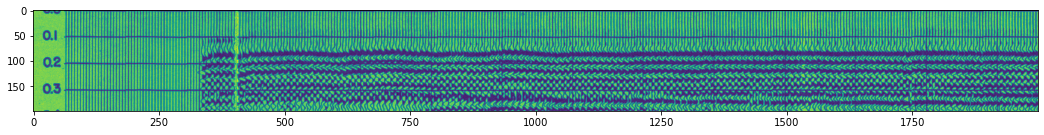

In [63]:
plt.figure(figsize=(18,6))
plt.imshow(StraightenedImage[:200,:2000])

In [47]:
cv2.cv.fromarray(clipped_im).save('mim.png')

AttributeError: module 'cv2' has no attribute 'cv'

In [48]:
cv2.imwrite('color_img.jpg', StraightenedImage)

True